In [2]:
import trimesh
from trimesh import transformations as trf
import numpy as np
import time
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [101]:
#for rotation
def trig(angle):
    r = np.deg2rad(angle)
    return r

def rotation_matrix(alpha=-90, beta=0, gamma=0):
    #rotate the mesh
    alpha = trig(alpha)
    beta = trig(beta)
    gamma = trig(gamma)

    origin, xaxis, yaxis, zaxis = [0, 0, 0], [1, 0, 0], [0, 1, 0], [0, 0, 1]

    Rx = trf.rotation_matrix(alpha, xaxis)
    Ry = trf.rotation_matrix(beta, yaxis)
    Rz = trf.rotation_matrix(gamma, zaxis)

    R = trf.concatenate_matrices(Rx, Ry, Rz)           
    R2=R[:3,:3]

    return R2

def write_csv_file(file_name, folder_name_list, vector_list):
    # Open a new CSV file for writing
    with open(file_name, 'w') as f:
        # Loop over the file_data list and write each row to the CSV file
        if len(folder_name_list) != len(vector_list):
            for i in range(len(vector_list)):
                file_name = folder_name_list[i]
                data = vector_list[i]
                # Write the file name to the first column
                f.write(file_name + ',')
                # Write the NumPy array to the remaining columns
                np.savetxt(f, data[np.newaxis], delimiter=',')


In [102]:
#Change the vectorization method to mesh.contains(points), 
#no need to calculate the sdf distance

def sdf_binary(mesh, x=50, y=20, z=20):
    '''
    calculate binary representation vector of a car shape
       input: mesh
       output: vector representation of a mesh
       [35, 12, 12] = 5040
       [40, 16, 16] = 10240
       [50, 20, 20] = 20000
       '''
    
    start_time = time.time()
    
    #original mass center and bounding box
    # print(mesh.center_mass)
    # bbx_ex = mesh.bounding_box.primitive.extents
    # print(bbx_ex)#bounding box size

    R2 = rotation_matrix(alpha=-90, beta=0, gamma=0)

    # The rotation matrix is applyed to the mesh
    mesh.vertices = np.matmul(mesh.vertices, R2)

    #set mass center to (0,0,0)
    mesh.vertices -= mesh.center_mass
    # print(mesh.center_mass)

    #rescale the mesh to real scale in meters
    mesh.vertices = mesh.vertices * 5
    # bbx_ex = mesh.bounding_box.primitive.extents
    # print(bbx_ex) #bounding box size
    
    #construct points matrix used to enclude the mesh
    x_p = np.linspace(-2.5, 2.5, x) 
    y_p = np.linspace(-1.0, 1.0, y)
    z_p = np.linspace(-1.0, 1.0, z)
    points = np.vstack(np.meshgrid(x_p, y_p, z_p)).reshape(3,-1).T
    
    #if a point inside the mesh
    sd = mesh.contains(points)
    #convert boolean to int
    sd = sd * 1
    
    #show execution time
    print("execution time: %s" %(time.time() - start_time))

    #visualization
    # Plot the trimesh object
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_trisurf(mesh.vertices[:, 0], mesh.vertices[:, 1], mesh.vertices[:, 2], triangles=mesh.faces, color='red')

    # Plot the point grid
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], color='blue', alpha=0.5)

    # Set the axis limits
    ax.set_xlim(-3, 3)
    ax.set_ylim(-2, 2)
    ax.set_zlim(-2, 2)

    # Show the plot
    plt.show()
    
    return sd

In [103]:
settings = [[35, 12, 12], [40, 16, 16], [50, 20, 20]]
dimensions = ['5040', '10240', '20000']
folders = [f for f in os.listdir('./cars')]

execution time: 0.13862347602844238


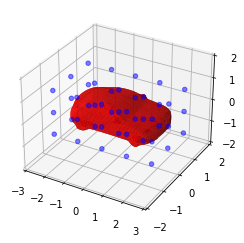

./cars/1079efee042629d4ce28f0f1b509eda/car_reg.obj
execution time: 0.12794160842895508


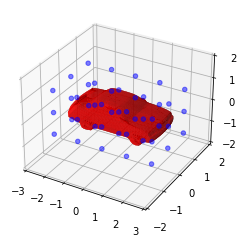

./cars/10c19d45fed88e6984c322bbb3fe1ad/car_reg.obj
execution time: 0.12834429740905762


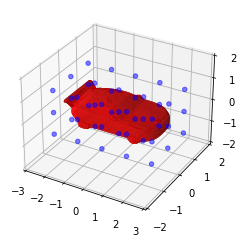

./cars/119464e186d8ef6f52aa494042b7c9db/car_reg.obj
execution time: 0.1266615390777588


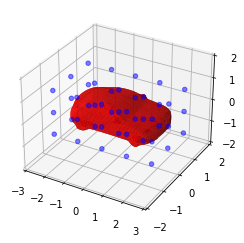

./cars/1079efee042629d4ce28f0f1b509eda/car_reg.obj
execution time: 0.12700223922729492


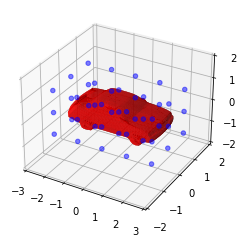

./cars/10c19d45fed88e6984c322bbb3fe1ad/car_reg.obj
execution time: 0.1258220672607422


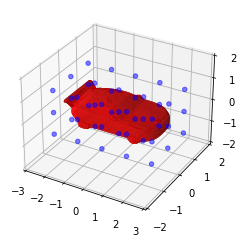

./cars/119464e186d8ef6f52aa494042b7c9db/car_reg.obj
execution time: 0.12227892875671387


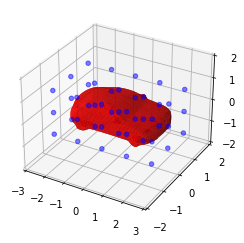

./cars/1079efee042629d4ce28f0f1b509eda/car_reg.obj
execution time: 0.1229546070098877


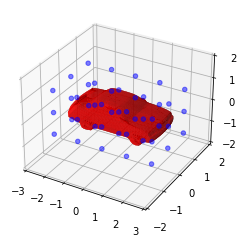

./cars/10c19d45fed88e6984c322bbb3fe1ad/car_reg.obj
execution time: 0.12221503257751465


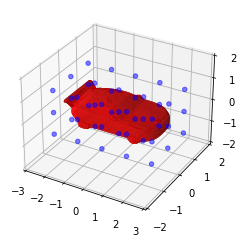

./cars/119464e186d8ef6f52aa494042b7c9db/car_reg.obj


In [104]:
for i, setting in enumerate(settings):
    dim = dimensions[i]
    vec_list = []
    x_pm, y_pm, z_pm = setting
    for folder in folders[:3]:
        mesh_file = os.path.join('./cars' + '/' + folder + '/' + 'car_reg_water.obj')
        mesh = trimesh.load(mesh_file)
        sd = sdf_binary(mesh, x=x_pm, y=y_pm, z=z_pm)
        vec_list.append(np.array(sd))
        # print(mesh_file)
    write_csv_file(f'./v_rep_{dim}.csv', folders, vec_list)

In [105]:
# np.savetxt(f'v_rep_{dim}.csv',sd_array, delimiter=',', fmt='%.2e')